In [1]:
import requests
from io import BytesIO
from PIL import Image

from torchvision import transforms
from transformers import OFATokenizer, OFAModel

from semshap.masking import generate_segmentation_masks
from semshap.plot import plot_masks

import torch.nn as nn
from semshap.explainers import BaseExplainer
from semshap.plot import barh, heatmap
import matplotlib.pyplot as plt

import torch

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/stego/train_segmentation.py:385: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


In [9]:
import sys
"semshap.stego" in sys.modules

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

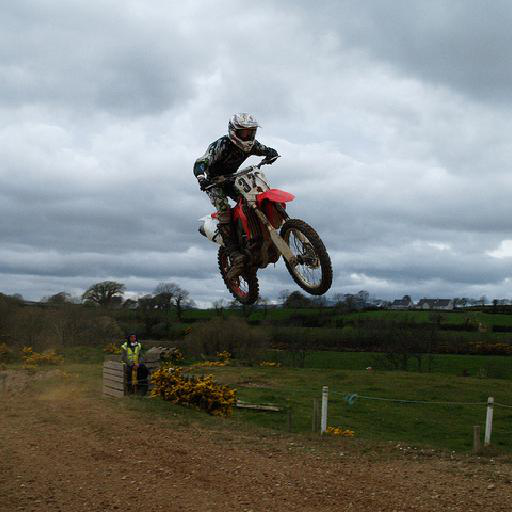

In [5]:
img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img

In [6]:
ckpt_dir = "OFA/ofa-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# load the model
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False).to(device)
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/venv369/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OFA/ofa-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


## Generate the semantic masks with STEGO

In [11]:
out = generate_segmentation_masks(img, method="cluster")
masks = out['masks']

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


(<Figure size 432x288 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object))

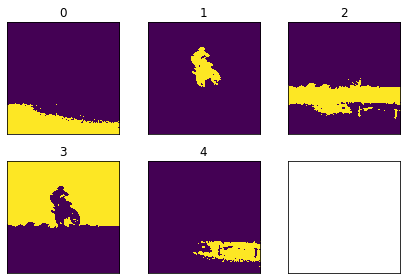

In [12]:
plot_masks(masks)

## Run the explainer

In [13]:
class ModelWrapper(nn.Module):
    def __init__(self, model, tokenizer, question, resolution, device="cpu"):
        super().__init__()
        
        self.resolution=resolution
        self.num_beams = 5
        self.no_repeat_ngram_size = 3
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.patch_resize_transform = transforms.Compose([
                                                            lambda image: image.convert("RGB"),
                                                            transforms.Resize(self.resolution, interpolation=Image.BICUBIC),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                                        ])
        
        self.inputs = tokenizer([question], return_tensors="pt").input_ids.to(self.device)
        
    

    def forward(self, img):
        # put here all to code to generate a caption from an image
        
        patch_img = self.patch_resize_transform(img).unsqueeze(0).to(self.device)
        out_ids = model.generate(self.inputs, patch_images=patch_img, num_beams=self.num_beams, 
                                 no_repeat_ngram_size=self.no_repeat_ngram_size)
        
        return tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0]

In [14]:
question = "What is the subject doing?"
model_wrapper = ModelWrapper(model, tokenizer, question, resolution=img.size, device=device)

In [15]:
model_wrapper(img)

' riding a dirt bike'

In [16]:
explainer = BaseExplainer(model_wrapper, device=device)

In [17]:
shap, base = explainer.explain(img, masks, k=-1)

100%|██████████| 32/32 [00:01<00:00, 16.39it/s]


Text(0.5, 1.0, 'Brute force KernelSHAP')

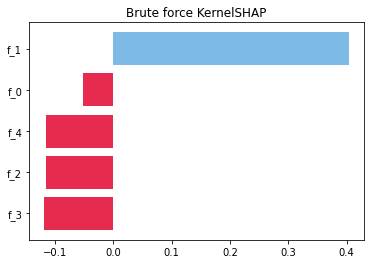

In [18]:
labels = [ f"f_{i}" for i in range(shap.shape[0]) ]
barh(labels, shap)

plt.title("Brute force KernelSHAP")

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/plot.py:60: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/plot.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7ff1564f9908>)

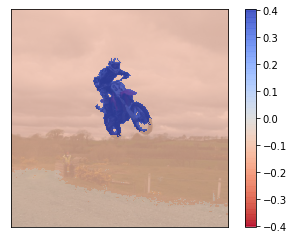

In [19]:
heatmap(img, masks, shap, alpha=0.75, vmin=-max(abs(shap)), vmax=max(abs(shap)))